## Part 3: Forecasting with off-the-shelf tabular models

In the previous part, we used **statistical forecasting methods** to predict the future values of a time-series given its past values. Statistical forecasting methods are sample-efficient, meaning they don't need a lot of data to get results. However, if you have a lot of data, they don't always benefit from it. Instead, when lots of data is available, more powerful machine learning methods can lean more complex patterns and make better forecasts.

In this notebook, we replace statistical forecasting models with a tabular one. Tabular models are models that work on tabular data (like Excel spreadsheets) instead of temporal data. Tabular data is very common in the industry and a lot of models have been developed for it. Converting temporal data into tabular data allows us to apply all of these tabular models for forecasting. In this notebook, we use the [Temporian](https://temporian.readthedocs.io/) library to do the conversion from temporal to tabular data.

We will use a tabular model called decision forests. Decision forests are notably easy and fast to train, making them suitable for prototyping and learning about methods. They provide good results and are partially interpretable, so they are worth sutdying. In this notebook, we use the [YDF](https://ydf.readthedocs.io) library to train the decision forests models.

In the previous parts, the setup was relatively simple. However, in many real-world applications, the setup is more complex. For instance:

- Multiple variables of interest may be involved.
- The data is not sampled uniformly. Different variables are sampled differently.
- Not all values are numerical; e.g. some may be categorical, free text, or images.
- Complex relationships and hierarchical structures may exist between different types of entities.
- Exogenous variables may be present, both with values known in advance (such as holiday dates) or not (such as oil prices).
- Features may require cleaning, preprocessing and data-augmentation before being consumed by a model.

To illustrate this complexity, we will use the Makridakis Forecasting Competition M5 dataset.

In [1]:
!pip install pandas temporian "matplotlib<3.9.0" ydf -U -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.6/760.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 14.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


<font color="red">WARNING:</font> Restart the notebook / colab kernel after the `pip install` commands above (e.g., Menu > Runtime / Restart settion). If you don't, you might get a `module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'` error.

In [1]:
# If SOLVING_EXERCISES=True, runs the user's answers.
# If SOLVING_EXERCISES=False, only runs the provided solutions.
SOLVING_EXERCISES = True

In [2]:
import pandas as pd
import temporian as tp
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import ydf
from io import StringIO
import numpy as np

pd.options.mode.chained_assignment = None
tp.config.display_max_indexes = 3
tp.config.display_max_events = 4

## The data: The M5 Competition

The [M5 Competition](https://www.kaggle.com/competitions/m5-forecasting-accuracy/overview) is the 2020 instance of the [Makridakis Forecasting Competitions](https://en.wikipedia.org/wiki/Makridakis_Competitions). The objective of this competition is to forecast the next 28 days of sales of 3k individual items in 10 different Walmart stores.

Walmart's data has a strong hierarchical structure, since each item belongs to a certain category and department, and each store to a certain state.
This means that, besides the 30k individual low-level time series corresponding to the daily sales of a specific item in a specific store (which we'll be referring to as an "item-store" or "level 12" time series), the data can be aggregated in multiple ways to generate a total of 42,840 time series to be forecasted, as shown in the images below.

In this notebook, we will stick to only predicting the sales of item-store series, though the data's hierarchical structure will come in handy in the feature engineering stage.

Details such as the [competition's guide](https://github.com/Mcompetitions/M5-methods/blob/master/M5-Competitors-Guide.pdf) and [Makridakis' analysis of the winning entries](https://www.researchgate.net/publication/344487258_The_M5_Accuracy_competition_Results_findings_and_conclusions) are available online.

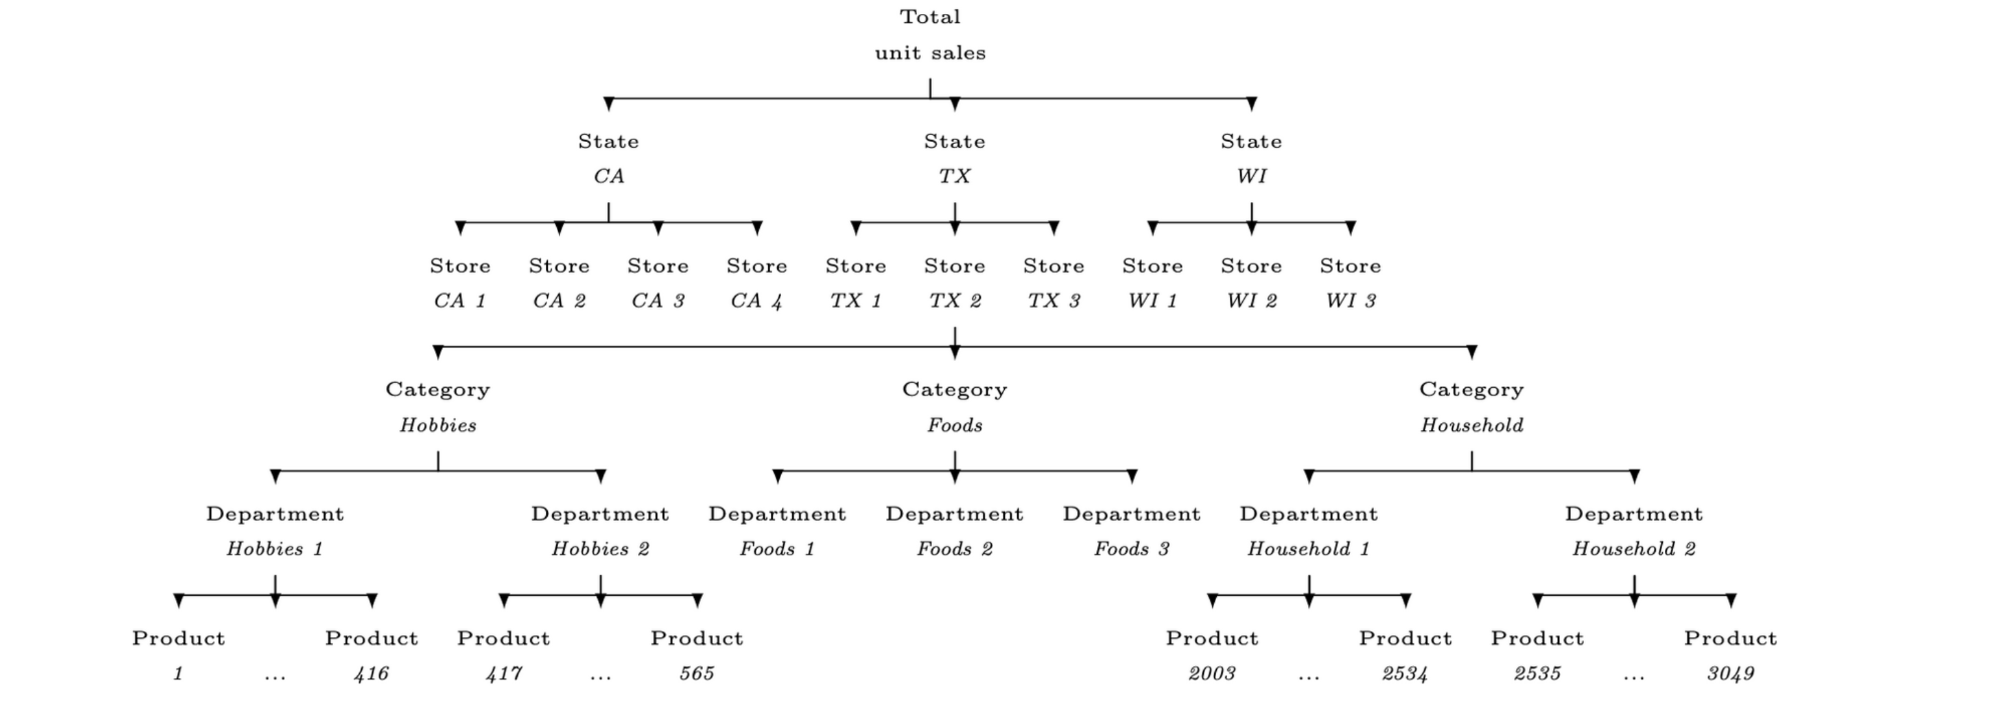
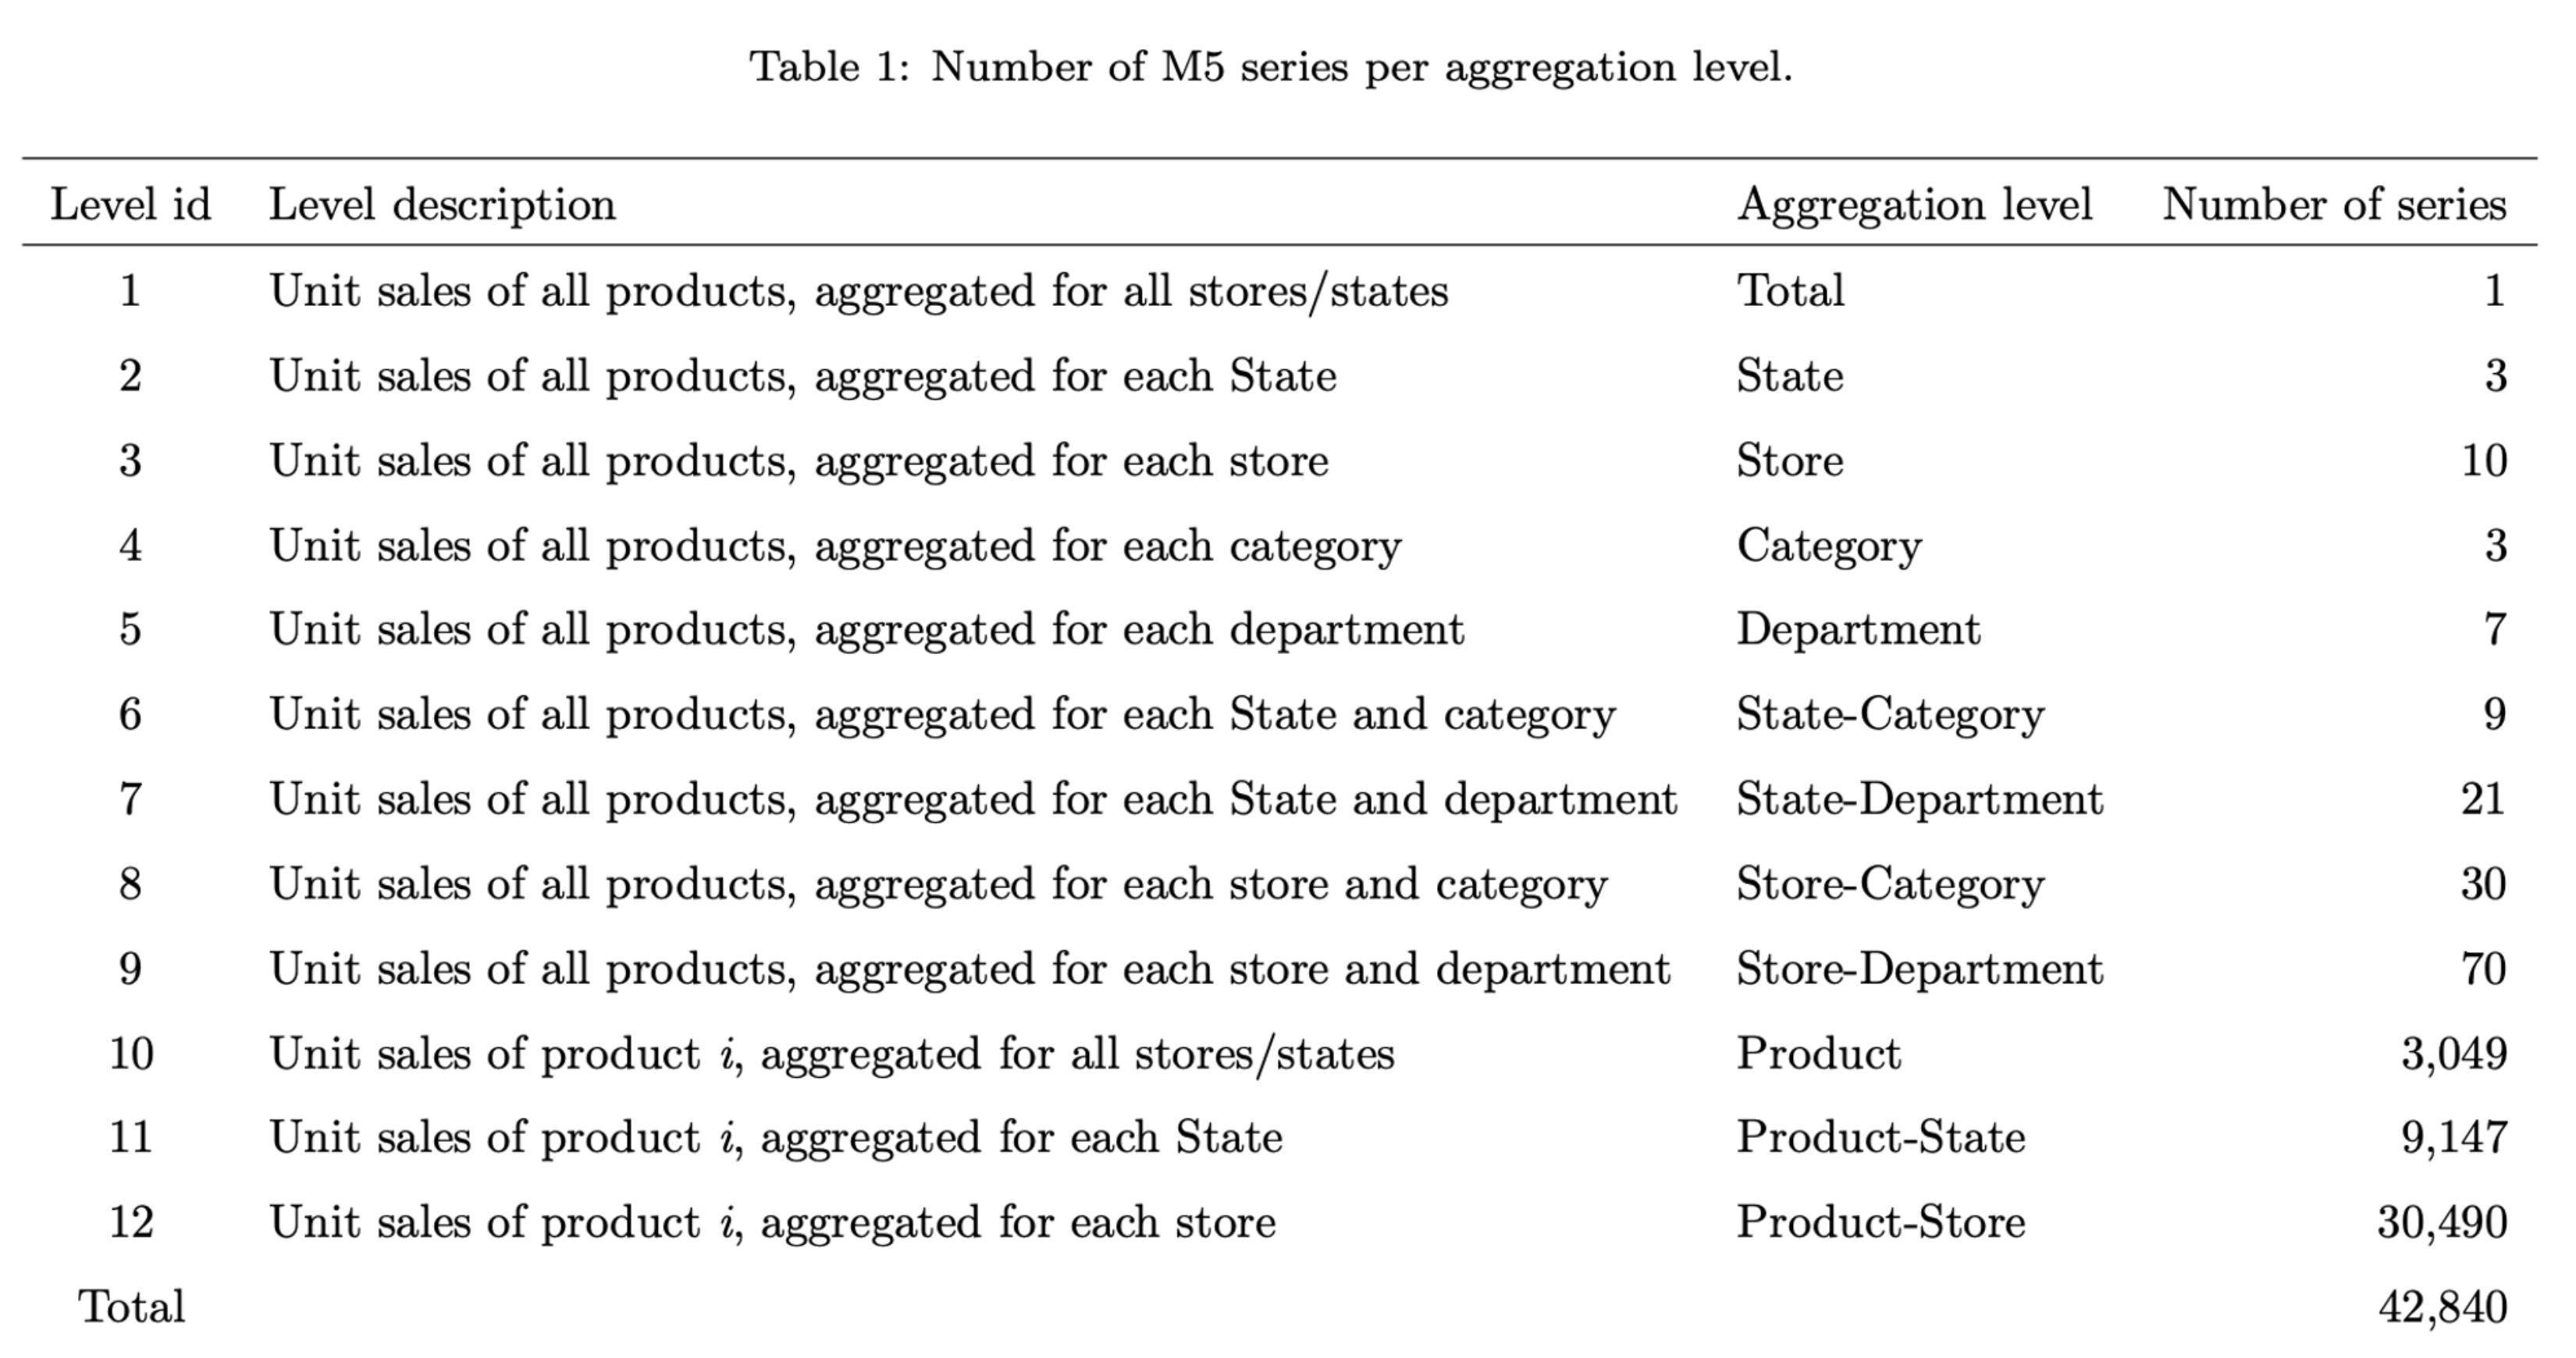

In [3]:
!wget https://scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com/datasets.zip
!unzip -o datasets.zip
!ls -lh datasets/m5

--2024-07-08 17:17:11--  https://scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com/datasets.zip
Resolving scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com (scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com)... 52.219.103.74, 3.5.129.167, 16.12.64.138, ...
Connecting to scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com (scipy-2024-tryo-google-datasets.s3.us-east-2.amazonaws.com)|52.219.103.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16389122 (16M) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===================>]  15.63M  14.4MB/s    in 1.1s    

2024-07-08 17:17:12 (14.4 MB/s) - ‘datasets.zip’ saved [16389122/16389122]

Archive:  datasets.zip
   creating: datasets/
   creating: datasets/m5/
  inflating: datasets/m5/sales_train_evaluation.csv  
  inflating: datasets/m5/calendar.csv  
  inflating: datasets/australian_tourism.csv  
  inflating: datasets/air_passengers.csv  
total 117M
-rw-r-----

The original dataset is composed of 5 CSV files:

- `sales_train_evaluation.csv`: The history of item sales.
- `calendar.csv`: Dates and calendar events related to the sales.
- `sell_prices.csv`: The history of the item prices.
- `sales_train_validation`: Another set of sales.
- `sample_submission`: An example of submission for the competition.

In this tutorial, we only use `sales_train_evaluation.csv` and `calendar.csv`.

First, let's load and take a look at the historical sales in  `sales_train_evaluation.csv`. Each row contains all the sales of an item+store pair (i.e. for a given item in a given store). Sales are aggregated per day. Each day, indexed between 1 and 1914 (5+ years), is stored in a different column.

In [4]:
raw_sales = pd.read_csv("datasets/m5/sales_train_evaluation.csv")
print("First 5 rows")
raw_sales.head()

First 5 rows


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


When working with time data, it is a good idea to take a look at the raw data. Let's plot the sales of the first three rows.

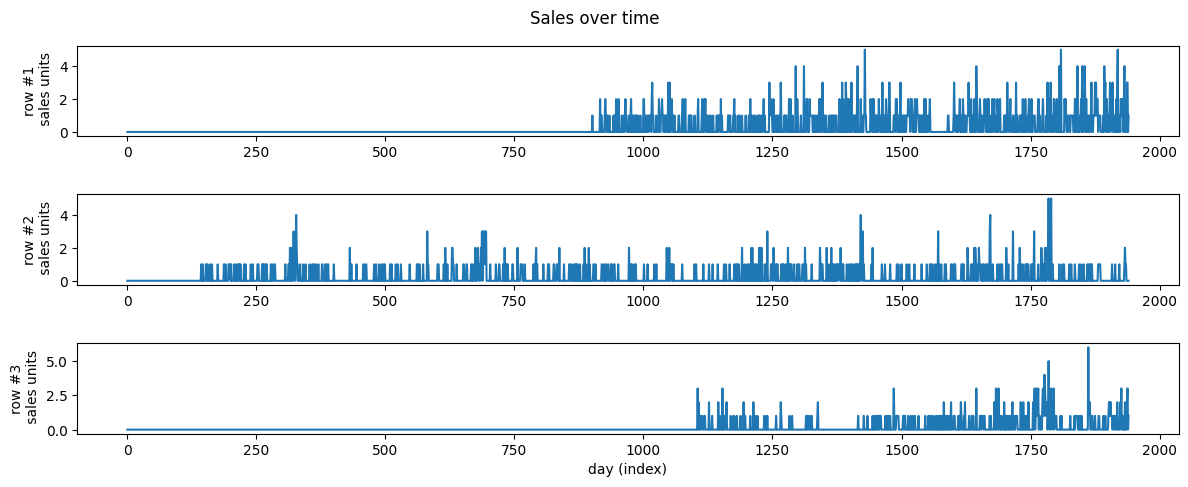

In [5]:
#@title
num_plots = 3
plt.figure(figsize=(12,2 * num_plots))
d_cols = list(raw_sales.filter(regex="d_"))

for row_idx in range(num_plots):
  sales_ts = raw_sales.iloc[row_idx][d_cols].to_numpy()
  plt.subplot(num_plots+1, 1, row_idx+1)
  plt.plot(sales_ts)
  plt.ylabel(f"row #{row_idx+1}\n sales units")

plt.suptitle("Sales over time")
plt.xlabel("day (index)")
plt.tight_layout()
plt.show()

#### Question

1. From those three plots, what can you tell already about the data?

#### Solution

(On those items)

1. Product sales are relatively sparse. It is common for a product not to sell on a given day, and there is rarely more than 4 sales per day. Predicting individual sparse sales could be difficult.
2. There are no sales of the first and last product during the first half of the dataset. As expected, some products can be added or removed from the shop.
3. Products show different sales patterns. Product #1 and #3 look quite irregular, while product #2 shows peaks every 365 days approx.
4. Product #1 and #3 have multi-days gap of sales. Maybe the product was not available at this time, for example because of being out of stock.
5. Only looking at 3 products with a simple (e.g., we don't see dates) resolution plotting (e.g., we cannot see individual days) can give an overview of what the data is about, but it does not tell us much more.


#### End of solution

## Subsampling sales

The sales are organized in two hierarchies: product/department/category and store/state. While we can predict the sales of each product in each store in isolation, the forecasts will likely be better if information is allowed to "flow" though the hierarchy. For instance, the sales of one same product in different stores, or the sales of products in the same department might be correlated.

**For fun:** Search for "diapers and beer correlation in retail".

In the previous part, we used hierarchical reconciliation to make hierarchy-aware forecasts: individual models were trained for each time series (a time series is equivalent to a product in a given store here) and their forecasts were normalized together. In this part, we will use a single global model: We will train a model with access to the hierarchy. The model is free to use or ignore the hierarchy.

To make the execution of the tutorial faster and more interesting, we downsample the dataset. We focus on a subset of the 8 food products with the largest sale counts.

In [6]:
if True: # Optional downsampling of the dataset.

    # The items with the most sales.
    selected_items_names = ['FOODS_3_090', 'FOODS_3_586', 'FOODS_3_252', 'FOODS_3_555',
                            'FOODS_3_587', 'FOODS_3_714', 'FOODS_3_694', 'FOODS_3_226',
                            #'FOODS_3_202', 'FOODS_3_120', 'FOODS_3_723', 'FOODS_3_635',
                            #'FOODS_3_808', 'FOODS_3_377', 'FOODS_3_541', 'FOODS_3_080',
                            #'FOODS_3_318', 'FOODS_2_360', 'FOODS_3_681', 'FOODS_3_234',
                           ]
    raw_sales = raw_sales[raw_sales["item_id"].isin(selected_items_names)]
    print("Number of time series:", len(raw_sales))

Number of time series: 80


Let's load the calendar events. Those are dates known in advance that might have impact on sales. For example, Christmas, father's day or the NBA Finals might impact purchases of different items.

This table is complementary to other possibly impactful calendar data, such as the day of the week or month of the year.

In [7]:
raw_calendar = pd.read_csv("datasets/m5/calendar.csv")
raw_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


## Normalize dataset

The tables `sales_raw` and `calendar_raw` represents temporal data in a different way. For example, timestamps are stored by columns in `sales_raw` and by rows in `calendar_raw`. The two tables also use a different system to represent dates.

To prepare, preprocess and augment the data, we use `pandas` and `temporian`. Pandas allows for general preprocessing of tabular data (using a structure called the `DataFrame`) while Temporian specializes on temporal data processing (using a structure  called the `EvenSet`).

Let's normalize all the the raw tables into the same format.

### Sidenote: A quick intro to Temporian

<img src="https://raw.githubusercontent.com/google/temporian/main/docs/src/assets/banner.png" alt="ydf logo" width="30%"/>


Temporian is a library to process and feature-engineer temporal data in python. Temporian is to temporal data what Pandas is to tabular data. For a quick introduction, see the [Getting started](https://temporian.readthedocs.io/en/latest/getting_started/) tutorial, though reading it is not necessary to continue this one.

Here is an example of what Temporian's syntax looks on some toy data:

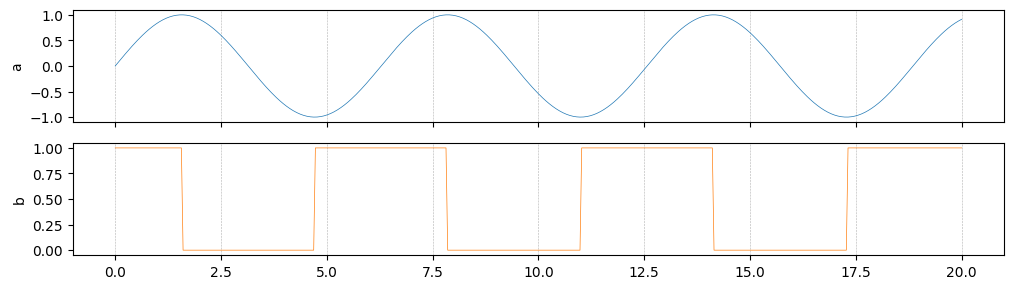

In [8]:
timestamp = np.linspace(0,20, 500)
# Creates a Temporian EventSet from a Pandas DataFrame.
events = tp.from_pandas(pd.DataFrame({
    "timestamp": timestamp,
    "a": np.sin(timestamp),
    "b": np.cos(timestamp) >= 0,
}))
# Plot the EventSet
events.plot()

In [9]:
# Filter events where "b" is true. Then extract "a" and multiply the value by 2.
x1 = events.filter(events["b"])["a"] * 2

# Two moving averages.
x2 = events["a"].simple_moving_average(1.0)
x3 = events["a"].simple_moving_average(2.5)

tp.plot([
    x1,
    (events["a"], x2, x3), # Group all those events sets in the same plot.
    ], interactive=True,  # Make the plot interractive.
        )

### Normalize sales

Each sales value is stored in a different column. Instead, we want for each value (which in Temporian we refer to as an event) to be in a different row.

For example, the record:

```
id,item_id,dept_id,d_1,d_2,d_3,...,d_n
```

will be converted to the following records:

```
id,item_id,dept_id,day,d_1
id,item_id,dept_id,day,d_2
...
id,item_id,dept_id,day,d_n
```

This "unpivot" operation can be done using Pandas's [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function.

#### Question

Fill the `unpivot` function below:



In [18]:
def test_unpivot(fn):
  """Unit test for unpivot."""

  output = fn(pd.read_csv(StringIO("""\
id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3
1,1,1,1,1,1,2,3,4
2,2,1,1,1,1,5,6,7
""")))
  print(f"output:\n{output}")
  expected_output = pd.read_csv(StringIO("""\
item_id,dept_id,cat_id,store_id,state_id,day,sales
1,1,1,1,1,1,2
2,1,1,1,1,1,5
1,1,1,1,1,2,3
2,1,1,1,1,2,6
1,1,1,1,1,3,4
2,1,1,1,1,3,7
"""))
  assert output.equals(expected_output)

if SOLVING_EXERCISES:

  def unpivot_solution(raw_sales):
    sales = pd.melt(raw_sales,var_name="day", value_name="sales", id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    )
    sales["day"] = sales["day"].apply(lambda x: int(x[2:]))
    del sales["id"]
    return sales

  test_unpivot(unpivot_solution)
  sales = unpivot_solution(raw_sales)

output:
   item_id  dept_id  cat_id  store_id  state_id  day  sales
0        1        1       1         1         1    1      2
1        2        1       1         1         1    1      5
2        1        1       1         1         1    2      3
3        2        1       1         1         1    2      6
4        1        1       1         1         1    3      4
5        2        1       1         1         1    3      7


#### Solution

In [ ]:
def unpivot_solution(raw_sales):
  sales = pd.melt(
      raw_sales,
      var_name="day",
      value_name="sales",
      id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
  )
  sales["day"] = sales["day"].apply(lambda x: int(x[2:]))
  del sales["id"] # Remove id
  return sales

test_unpivot(unpivot_solution)

sales = unpivot_solution(raw_sales)

#### End of solution

### Normalize dates in sales

The timestamps are expressed as numbers of days since `29/1/2011`.
Let's convert them into UTC python datetimes.

In [19]:
def test_convert_day_count_to_datetime(fn):
  assert fn(1) == datetime(2011, 1, 29, tzinfo=timezone.utc)
  assert fn(2) == datetime(2011, 1, 30, tzinfo=timezone.utc)
  assert fn(3) == datetime(2011, 1, 31, tzinfo=timezone.utc)

if SOLVING_EXERCISES:

  origin_date = datetime(2011, 1, 29, tzinfo=timezone.utc)
  def convert_day_count_to_datetime(day):
    return origin_date + timedelta(days=day - 1)


  test_convert_day_count_to_datetime(convert_day_count_to_datetime)


#### Solution

In [ ]:
origin_date = datetime(2011, 1, 29, tzinfo=timezone.utc)
def convert_day_count_to_datetime(day):
  return origin_date + timedelta(days=day - 1)

test_convert_day_count_to_datetime(convert_day_count_to_datetime)

#### End of solution

In [20]:
origin_date = datetime(2011, 1, 29, tzinfo=timezone.utc)
sales["timestamp"] = sales["day"].apply(convert_day_count_to_datetime)
del sales["day"]
sales

,item_id,dept_id,cat_id,store_id,state_id,sales,timestamp
0,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,107,2011-01-29 00:00:00+00:00
1,FOODS_3_226,FOODS_3,FOODS,CA_1,CA,13,2011-01-29 00:00:00+00:00
2,FOODS_3_252,FOODS_3,FOODS,CA_1,CA,19,2011-01-29 00:00:00+00:00
3,FOODS_3_555,FOODS_3,FOODS,CA_1,CA,23,2011-01-29 00:00:00+00:00
4,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,2011-01-29 00:00:00+00:00
...,...,...,...,...,...,...,...
155275,FOODS_3_555,FOODS_3,FOODS,WI_3,WI,39,2016-05-22 00:00:00+00:00
155276,FOODS_3_586,FOODS_3,FOODS,WI_3,WI,37,2016-05-22 00:00:00+00:00
155277,FOODS_3_587,FOODS_3,FOODS,WI_3,WI,24,2016-05-22 00:00:00+00:00
155278,FOODS_3_694,FOODS_3,FOODS,WI_3,WI,48,2016-05-22 00:00:00+00:00


Let's now convert `sales` from a Pandas DataFrame to a Temporian EventSet using Temporian's [from_pandas](https://temporian.readthedocs.io/en/latest/reference/temporian/io/from_pandas/) function.

We will set all of the hierarchical features as the EventSet's `indexes`, which lets Temporian know that the records with the same value in those columns correspond to the same individual time series.

**Note:** Temporian supports creating EventSets from several common data formats (e.g., csv, parquet, pandas, polars, tensorflow datasets).


In [21]:
sales = tp.from_pandas(
    sales,
    indexes=["item_id", "dept_id", "cat_id", "store_id", "state_id"],
)
sales

timestamp,sales
2011-01-29 00:00:00+00:00,107
2011-01-30 00:00:00+00:00,182
…,…
2016-05-21 00:00:00+00:00,67
2016-05-22 00:00:00+00:00,64
timestamp,sales
2011-01-29 00:00:00+00:00,116
2011-01-30 00:00:00+00:00,90
…,…
2016-05-21 00:00:00+00:00,63


Let's plot the sales of the first three products.

In [22]:
sales.plot(max_num_plots=3, interactive=True)

Note that `sales` is indexed by product, department, category, store and state.

#### Question

1. Zoom in the plot and find the number of sales of the first item on 24 Dec. 2014.

#### Solution


25 units of the first product were sold on 24 Dec. 2014.

### Normalize dates in `raw_calendar`

In `raw_calendar`, timestamps are expressed as ISO 8601 string e.g., `2011-01-29`. Let's convert them into python datetimes.

In [23]:
calendar = raw_calendar.copy()

# Both Temporian and YDF (see later) treat NaN values as "missing".
# In this dataset, a NaN means that there is no calendar event on this day.
calendar.fillna("no_event", inplace=True)

calendar["timestamp"] = calendar["date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

# We keep the mapping wm_yr_wk -> timestamp to clean "raw_sell_prices" in the next section.
wm_yr_wk_map = calendar[["weekday", "timestamp", "wm_yr_wk"]]

del calendar["date"]
del calendar["wm_yr_wk"]
del calendar["d"]
del calendar["weekday"]
del calendar["wday"]
del calendar["month"]
del calendar["year"]

calendar

,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,timestamp
0,no_event,no_event,no_event,no_event,0,0,0,2011-01-29
1,no_event,no_event,no_event,no_event,0,0,0,2011-01-30
2,no_event,no_event,no_event,no_event,0,0,0,2011-01-31
3,no_event,no_event,no_event,no_event,1,1,0,2011-02-01
4,no_event,no_event,no_event,no_event,1,0,1,2011-02-02
...,...,...,...,...,...,...,...,...
1964,no_event,no_event,no_event,no_event,0,1,1,2016-06-15
1965,no_event,no_event,no_event,no_event,0,0,0,2016-06-16
1966,no_event,no_event,no_event,no_event,0,0,0,2016-06-17
1967,no_event,no_event,no_event,no_event,0,0,0,2016-06-18


Same as before, we can convert the calendar data into a Temporian EventSet.


In [24]:
calendar = tp.from_pandas(calendar)
calendar

timestamp,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
2011-01-29 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2011-01-30 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
…,…,…,…,…,…,…,…
2016-06-18 00:00:00+00:00,no_event,no_event,no_event,no_event,0,0,0
2016-06-19 00:00:00+00:00,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


Note that `calendar` is not indexed: All the events are global.

## Feature engineering

The methods shown in part 2 were able to consume time series natively. However, generic tabular machine learning models such as decision forests are not. Instead, as the name suggests, these algorithms consume tables of data, where each row is an independent observation.

We could feed each row of our dataset to the model, but it would not be that interesting: the model would be trained to predict the sales of day `t` using all the information available at day `t`. While possibly interesting, this is not much of a forecast.

Instead, we want to predict the sales at day `t+h` (`h>0`) using information available at day `t`. In other words, we want to predict some rows from other rows.

The simplest solution for that is to perform feature engineering, which Temporian specializes in.

### Basic preprocessing : lagged sales

We have to choose what each row of the preprocessed dataset represents.

A good convention, which helps avoiding future leakage in pipeline, is to attach a timestamp to each row and enforce that the row only contains information available at its timestamp. For example, a row with timestamp `2022-09-12` can only contain data derived from observations at or anterior to `2022-09-12`.

Remember: future leakage refers to the unintentional exposure of future data to the model, allowing it to "see the future" and reach much better results than it will when deployed to production.

The simplest way to carry anterior data is with the `lag` operator. For instance,
on day `2022-09-12`, we make the model have access to the sales on `2022-09-11` (lag of one day) and `2022-09-10` (lag of two days).

Complete the `lag_sales` function below which computes lagged values.

In [25]:
def test_lag_sales(fn):
  """Check the lag_sales function."""
  output = fn(tp.event_set(
      timestamps=[datetime(2011, 1, 28, tzinfo=timezone.utc),
                  datetime(2011, 1, 29, tzinfo=timezone.utc),
                  datetime(2011, 1, 30, tzinfo=timezone.utc),
                  datetime(2011, 1, 31, tzinfo=timezone.utc),
                  ],
      features={"sales": [1, 2, 3, 4]},
      ), horizon=2)
  expected_output = tp.event_set(
      timestamps=[datetime(2011, 1, 28, tzinfo=timezone.utc),
                  datetime(2011, 1, 29, tzinfo=timezone.utc),
                  datetime(2011, 1, 30, tzinfo=timezone.utc),
                  datetime(2011, 1, 31, tzinfo=timezone.utc),
                  ],
      features={"sales": [0, 0, 1, 2]},
      )
  print(output)
  assert output == expected_output

if SOLVING_EXERCISES:
  def lag_sales(sales, horizon: int):
    # This function lags the content of "sales" by "horizon" days,
    # and re-synchronizes it to "sales".
    #
    # You will need the following functions:
    # https://temporian.readthedocs.io/en/latest/reference/temporian/operators/lag/
    # https://temporian.readthedocs.io/en/latest/reference/temporian/operators/resample/

    x = sales
    x = x.lag(tp.duration.days(horizon))
    x = x.resample(sales)
    return x


    test_lag_sales(lag_sales)

#### Solution

In [ ]:
def lag_sales(sales, horizon: int):
  x = sales
  x = x.lag(tp.duration.days(horizon))
  x = x.resample(sales)
  return x
test_lag_sales(lag_sales)

**Note:** To learn more about Temporian preprocessing and capabilities, check the [getting started](https://temporian.readthedocs.io/en/latest/getting_started/) notebook.

The dataset is too large to be plotted. Instead, we will plot the preprocessing on a single randomly selected product and for a short period of time.

#### End of solution

In [26]:
lagged_sales_list : list[tp.EventSet] = []
for horizon in [1, 2, 3, 7, 14]:
  lagged_sales = lag_sales(sales, horizon=horizon)
  lagged_sales_list.append(lagged_sales.rename(f"f_sales_lag{horizon}"))
feature_lagged_sales = tp.glue(*lagged_sales_list)

In [27]:
# Select a product.
selected_index = sales.get_arbitrary_index_key()
print("Selected product (selected_index):", selected_index)

Selected product (selected_index): (b'FOODS_3_694', b'FOODS_3', b'FOODS', b'WI_2', b'WI')


The number of plots (5) is larger than "options.max_num_plots=4". Only the first plots will be printed.


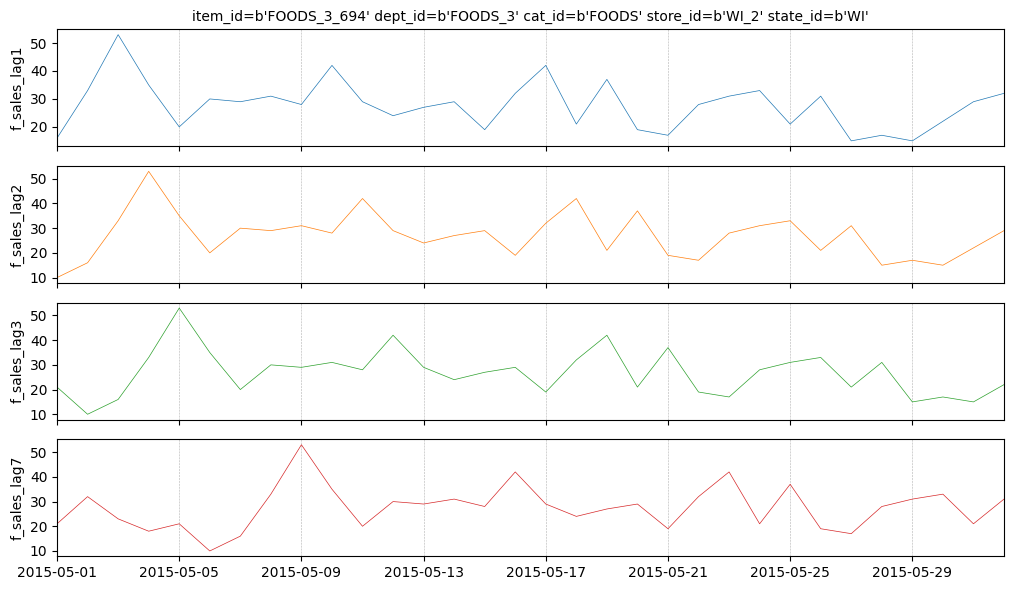

In [28]:
plot_options = {
    # Only plot the selected product.
    "indexes": selected_index,
    # Optional: Make the plot interactive.
    # "interactive": True,
    # Only plot the data for the year 2015.
    "min_time": datetime(2015, 5, 1),
    "max_time": datetime(2015, 6, 1),
}
feature_lagged_sales.plot(**plot_options, max_num_plots=4)

#### Question

1. Can you see the "shift" of the label as the lag increases?
2. What would a shift in the other direction mean?

#### Solution


1. Yes. The larger the lag, the more the shift goes to the right / future.
2. A shift in the other direction would be delaying data, i.e. bringing future data into the past.

#### End of solution

### Preparing labels

The label is the only column that does not follow the future leakage restriction of the features. It is actually the opposite: predicting the label should be a forecast, therefore labels at time `t` should tell us something about the future, such as the sales at the `t+1`.

Our goal in this tutorial is to forecast the sales for the next 14 individual days. Therefore, we create those 14 labels.

In [29]:
# Prediction horizon. In the M5 competition, participants should forecast the
# next 28 days. Here, we only predict the next 14 days to make the notebook run
# faster (replace 14 by 28 in the next line to forecast the next 28 days).
horizons = list(range(1, 14))

# This code is almost exactly the same as the lag computation above.
# Instead of the "lag" function, we use the "leak" function:
# https://temporian.readthedocs.io/en/latest/reference/temporian/operators/leak/
#
# Note: "leak" is the only Temporian function that can create data leakage - if
# your features do not depend on a the result of the "leak" function, you are
# sure there is no future leakage in your data :).
#
# Bonus: You can check if a feature depends indirectly on the result of a "leak"
# operator with the "has_leak" function. But this is outside the scope of this
# tutorial.
# https://temporian.readthedocs.io/en/latest/reference/temporian/has_leak/

# For each of the horizons.
label_list: list[tp.EventSet] = []
for horizon in horizons:
    # Leak the sales in the past.
    x = sales["sales"].leak(tp.duration.days(horizon))

    # Resample the label to the sales data.
    x = x.resample(sales)

    # Give a name to the label for book-keeping.
    x = x.rename(f"label_h{horizon}")
    label_list.append(x)

labels = tp.glue(*label_list)

Let's see what the labels look like. As stated in the last question's solution, leaking the data shifts it to the left, "delaying" it or bringing it into the past.


The number of plots (13) is larger than "options.max_num_plots=4". Only the first plots will be printed.


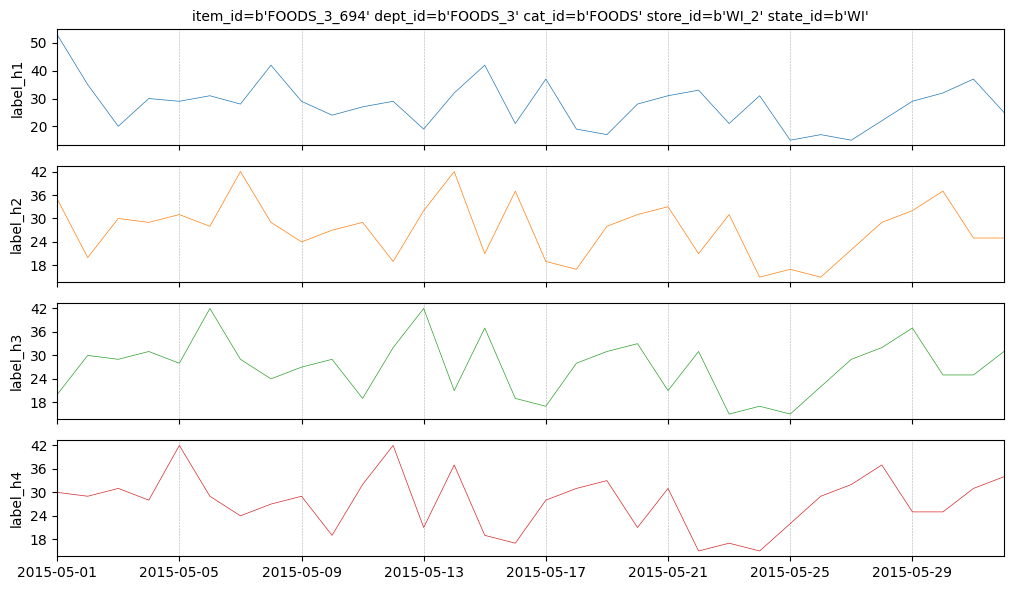

In [30]:
labels.plot(**plot_options, max_num_plots=4)

## Train and evaluate a first model

We can now train and evaluate our first model using only lagged sales as features.

We use a train and test protocol to evaluate our model.

In classical tabular machine learning, train and test examples can be separated randomly. However, because of the time dependency between our rows, and because we want to apply our forecasting model in the future (and not in the past - we are not archeologists), it is important for the training examples to be anterior to the test examples.

The dataset ranges from `2011-01-29` to `2016-06-19`. We will use the data starting in Feb. `2016` for testing, and previous data for training.

In [31]:
end_train_cutoff = datetime(2016, 2,1)

Our lag features depend on sales 14 days in the past. Therefore, at the start of the dataset, these feature are not available. For example, on day `2011-01-29`, we have no sales records for 14 days before.

Therefore, we will start the training dataset on `2011-02-15`. Note that values from the first two weeks of data will still be available in the lag features.

In [32]:
start_train_cutoff = datetime(2011, 2,15)

Let's split the data.

Use Temporian's [before](https://temporian.readthedocs.io/en/latest/reference/temporian/operators/before) and [after](https://temporian.readthedocs.io/en/latest/reference/temporian/operators/after/) functions to extract a training and testing dataset.

The training dataset contains the data between `start_train_cutoff` and `end_train_cutoff`. The testing dataset contains the data after `end_train_cutoff`.

In [34]:
def test_split_train_test(fn):
  """Test the split_train_test function."""
  output_train, output_test = fn(tp.event_set(
      timestamps=[datetime(2011, 2, 1, tzinfo=timezone.utc),
                  datetime(2011, 2, 16, tzinfo=timezone.utc),
                  datetime(2016, 1, 1, tzinfo=timezone.utc),
                  datetime(2011, 2, 15, tzinfo=timezone.utc),
                  ]))
  expected_output_train = tp.event_set(
      timestamps=[datetime(2011, 2, 16, tzinfo=timezone.utc),
                  datetime(2016, 1, 1, tzinfo=timezone.utc),
                  ])
  expected_output_test = tp.event_set(
      timestamps=[datetime(2011, 2, 15, tzinfo=timezone.utc)])
  print(output_train)
  print(output_test)
  assert output_train == expected_output_train
  assert output_test == expected_output_test

if SOLVING_EXERCISES:

  def split_train_test(data : tp.EventSet):
    train_data = data.after(start_train_cutoff).before(end_train_cutoff)
    test_data = data.after(end_train_cutoff)
    return train_data, test_data

  test_split_train_test(split_train_test)


indexes: []
features: []
events:
     (2 events):
        timestamps: ['2011-02-16T00:00:00' '2016-01-01T00:00:00']
        
memory usage: 416 B

indexes: []
features: []
events:
     (0 events):
        timestamps: []
        
memory usage: 400 B



#### Solution

In [ ]:
def split_train_test(data : tp.EventSet):
  train_data = data.after(start_train_cutoff).before(end_train_cutoff)
  test_data = data.after(end_train_cutoff)
  return train_data, test_data

test_split_train_test(split_train_test)

#### End of solution

In [35]:
# Make sure the model also has access to the raw sales.
feature_sales = sales

features_and_labels = tp.glue(feature_sales, feature_lagged_sales, labels)
train_examples, test_examples = split_train_test(features_and_labels)

print("Number of train examples:", train_examples.num_events())
print("Number of test examples:", test_examples.num_events())

Number of train examples: 144880
Number of test examples: 8880


We train a separate model for each of the labels and aggregate the predictions.

In [36]:
feature_names = feature_sales.schema.feature_names() + feature_lagged_sales.schema.feature_names()
label_names = labels.schema.feature_names()

print("feature_names:", feature_names)
print("label_names:", label_names)

feature_names: ['sales', 'f_sales_lag1', 'f_sales_lag2', 'f_sales_lag3', 'f_sales_lag7', 'f_sales_lag14']
label_names: ['label_h1', 'label_h2', 'label_h3', 'label_h4', 'label_h5', 'label_h6', 'label_h7', 'label_h8', 'label_h9', 'label_h10', 'label_h11', 'label_h12', 'label_h13']


### Sidenote: A quick intro to YDF

<img src="https://ydf.readthedocs.io/en/latest/image/logo_v2.png" alt="ydf logo" width="30%"/>


[YDF](https://ydf.readthedocs.io) is Google's library to train, evaluate, interpret, and serve Random Forest, Gradient Boosted Decision Trees, CART, and other decision forest models. YDF, previously known as [TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests), is specialized for rapid prototyping and development while minimizing risk of modeling errors.

For a quick introduction, see the [Getting started](https://ydf.readthedocs.io/en/latest/tutorial/getting_started/) notebook, though reading it is not necessary to continue this tutorial.

Here is what YDF code looks on some toy data:

In [37]:
# Generate some training and testing examples.
def gen_data():
  n = 10_000
  f1 = np.random.uniform(size=n) # A numerical feature
  f2 = np.random.choice(["a", "b","c"], size=n) # A categorical feature
  label = (f1 + (f2 == "a") + np.random.uniform(size=n)) > 1.5
  return pd.DataFrame({
      "f1": f1,
      "f2": f2,
      "label": label,
  })

train_dataset = gen_data()
test_dataset = gen_data()

train_dataset.head()

,f1,f2,label
0,0.654543,b,False
1,0.623592,c,False
2,0.678770,a,True
3,0.805625,c,False
4,0.101155,b,False


In [38]:
# Train a model
model = ydf.GradientBoostedTreesLearner(label="label").train(train_dataset)

# Evaluate model
print("Model evaluation:\n", model.evaluate(test_dataset))

# Display model details
model.describe()

Train model on 10000 examples
Model trained in 0:00:00.772872
Model evaluation:
 accuracy: 0.8715
confusion matrix:
    label (row) \ prediction (col)
    +-------+-------+-------+
    |       | false |  true |
    +-------+-------+-------+
    | false |  5732 |   433 |
    +-------+-------+-------+
    |  true |   852 |  2983 |
    +-------+-------+-------+
characteristics:
    name: 'true' vs others
    ROC AUC: 0.953164
    PR AUC: 0.933719
    Num thresholds: 678
loss: 0.256546
num examples: 10000
num examples (weighted): 10000



### Training YDF models

#### Direct vs. recursive multi-step forecasting

Note that in part 2, even though we were also predicting for several days ahead, we were training a single model. That model was used recursively to generate the forecasts - i.e., the forecast for time `t+1` was generated using data up until time `t`, then the prediction for `t+1` was used to generate `t+2`, and so on. This is known as *recursive forecasting*.

Here, instead, we'll be doing *direct forecasting*, which entails training an independent model for each of our forecasting horizons. In this case, the prediction for any time `t+n` only uses data up until `t`.

In [39]:
def train_models(train_examples):
    models = []
    for label_name in label_names:
        print(f"Train model for label {label_name!r}")

        # To train the model, we use YDF.
        # YDF consumes natively Pandas dataframes so we convert the
        # pre-processedTemporian EventSets into Pandas DataFrames before
        # training.
        train_examples_df = tp.to_pandas(train_examples)

        # We configure the learning algorithm.
        learner = ydf.GradientBoostedTreesLearner(
            task=ydf.Task.REGRESSION,
            label=label_name, # Name of the column containing the label.
            num_trees=40,  # Increase the number of trees (e.g., 100) for a more capable model.
            features=feature_names,
            # Check the hyper-parameter and hyper-parameter recommendations to
            # boost the model quality.
            # https://ydf.readthedocs.io/en/latest/hyperparameters
            # https://ydf.readthedocs.io/en/latest/guide_how_to_improve_model
            #
            # Note that we currently only using lagged features. Wait to have more
            # features (later in this notebook) before tuning the
            # hyper-parameters.
        )

        # Train the model
        model = learner.train(train_examples_df)

        models.append(model)
    return models

models = train_models(train_examples)

Train model for label 'label_h1'
Train model on 144880 examples
Model trained in 0:00:08.572579
Train model for label 'label_h2'
Train model on 144880 examples
Model trained in 0:00:07.143993
Train model for label 'label_h3'
Train model on 144880 examples
Model trained in 0:00:08.613581
Train model for label 'label_h4'
Train model on 144880 examples
Model trained in 0:00:07.449046
Train model for label 'label_h5'
Train model on 144880 examples
Model trained in 0:00:08.004784
Train model for label 'label_h6'
Train model on 144880 examples
Model trained in 0:00:08.593644
Train model for label 'label_h7'
Train model on 144880 examples
Model trained in 0:00:07.160371
Train model for label 'label_h8'
Train model on 144880 examples
Model trained in 0:00:08.547974
Train model for label 'label_h9'
Train model on 144880 examples
Model trained in 0:00:08.565442
Train model for label 'label_h10'
Train model on 144880 examples
Model trained in 0:00:07.145565
Train model for label 'label_h11'
Train

`models` contains one model for each of our forecasting horizons - i.e., we have 14 models, predicting for days 1 to 14 into the future. Lets use YDF's [describe](https://ydf.readthedocs.io/en/latest/py_api/GenericModel/#ydf.GenericModel.describe) function to look at the model.

In [40]:
# Information about the last trained model.
models[-1].describe()

#### Question

1. Look at the variable importance of the model. Which feature is the most important? Does this make sense?
1. Look at the training logs of the model. Is the model overfitting? Is the model continuing to improve?

#### Solution


1.

The most important features are the current day sales, followed by the one day lag. It means that to predict future sales, the most recent sales values are the most important.

Note that lag 7 and lag 14 have almost the same importance, which is much more important that lag 3. Many human activities have a strong weekly cyclical pattern, therefore it makes sense for the sales of the same day last week (or the week before) to be good predictors.

2.

The training and validation losses are close and the validation loss is still decreasing indicating that the model is not overfitting. However, the validation/training loss is almost flat which indicate the model is not able to learn more. This make sense as the model only has access to a few basic features.


#### End of solution

Let's evaluate the quality of the model using the test dataset.
A simple solution to quantify the quality of numerical predictions is to use the [RMSE](https://en.wikipedia.org/wiki/Root_mean_square_deviation) (for Root Mean Squared Error).

**Note:** The RMSE can be interpreted as the "spread" of the prediction around the real values. The unit of the RMSE is the same as the unit of the label i.e. a count of sales in this dataset.

In [41]:
def evaluate_models(models, test_examples):
    test_examples_df = tp.to_pandas(test_examples)
    rmses = []
    for model in models:
        evaluation = model.evaluate(test_examples_df)
        rmses.append(evaluation.rmse)
        print(f"RMSE for label {model.label()!r}: {evaluation.rmse:.4f}")
    return rmses

rmses_per_horizon_lag_features = evaluate_models(models, test_examples)

RMSE for label 'label_h1': 11.9069
RMSE for label 'label_h2': 13.8899
RMSE for label 'label_h3': 13.3918
RMSE for label 'label_h4': 11.9862
RMSE for label 'label_h5': 11.5462
RMSE for label 'label_h6': 11.2584
RMSE for label 'label_h7': 11.1346
RMSE for label 'label_h8': 12.9439
RMSE for label 'label_h9': 14.4697
RMSE for label 'label_h10': 13.9256
RMSE for label 'label_h11': 12.5902
RMSE for label 'label_h12': 12.2275
RMSE for label 'label_h13': 11.8516


This model is not that accurate, but it is a good baseline for later.

We compute and store the predictions of the models (i.e., each horizon) into an EventSet.

In [42]:
def compute_predictions(models, test_examples):
    test_examples_df = tp.to_pandas(test_examples, timestamp_to_datetime=True)
    index_names = test_examples.schema.index_names()
    predictions = test_examples_df[["timestamp"] + index_names]
    for model in models:
        raw_predictions = model.predict(test_examples_df)
        predictions.loc[:,model.label()] = raw_predictions
    return tp.from_pandas(predictions, indexes = index_names)

predictions = compute_predictions(models, test_examples)
predictions

timestamp,label_h1,label_h2,label_h3,label_h4,label_h5,label_h6,label_h7,label_h8,label_h9,label_h10,label_h11,label_h12,label_h13
2016-02-02 00:00:00+00:00,39.58,44.27,50.36,53.18,46.99,42.61,39.76,41.32,44.84,51.67,55.84,45.5,41.89
2016-02-03 00:00:00+00:00,42.32,43.62,41.3,41.29,40.62,38.71,37.11,38.36,40.46,40.42,41.5,39.92,36.25
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-05-21 00:00:00+00:00,60.17,53.14,47.51,48.56,51.01,59.72,59.87,57.36,50.16,49.62,50.35,51.99,59.96
2016-05-22 00:00:00+00:00,66.24,60.27,57.61,58.58,60.56,69.16,69.88,67.35,60.48,58.38,55.03,61.08,69.83
timestamp,label_h1,label_h2,label_h3,label_h4,label_h5,label_h6,label_h7,label_h8,label_h9,label_h10,label_h11,label_h12,label_h13
2016-02-02 00:00:00+00:00,31.79,36.81,48.06,57.65,46.24,33.39,28.73,32.4,39.26,48.42,55.97,47.4,31.14
2016-02-03 00:00:00+00:00,31.09,35.62,40.5,40.39,30.8,26.02,27.14,26.46,32.31,38.44,39.64,29.07,25.89
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2016-05-21 00:00:00+00:00,60.18,54.34,47.4,48.22,51.51,64.5,67.89,63.46,51.89,47.63,47.05,50.47,63.07


/usr/local/lib/python3.10/dist-packages/temporian/implementation/numpy/data/plotter_matplotlib.py:108: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout()


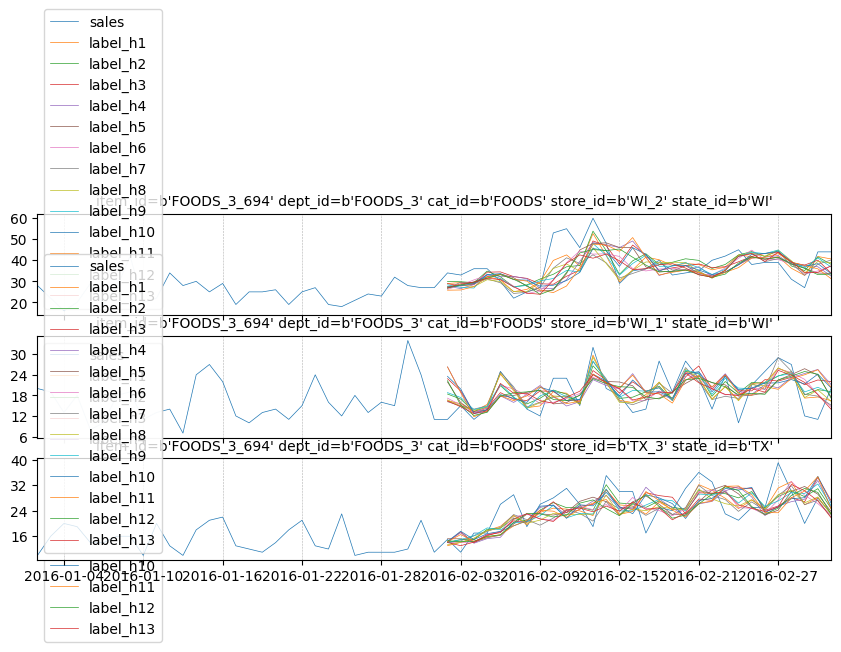

In [43]:
# This plot shows the sales of 3 products as well as the predictions of each of
# the models. In other words, each line in the "spaghetti block" (on the right)
# shows the forecasting with a different horizon.
tp.plot([sales["sales"], predictions],
    max_num_plots=3,
    merge=True,
    min_time= end_train_cutoff - timedelta(days=30),
    max_time= end_train_cutoff + timedelta(days=30),
)

Plotting each horizon individually makes the plot unintuitive. Instead of plotting each prediction horizon separately, we want to plot (and connect) the prediction of each model on the last day of our train set.

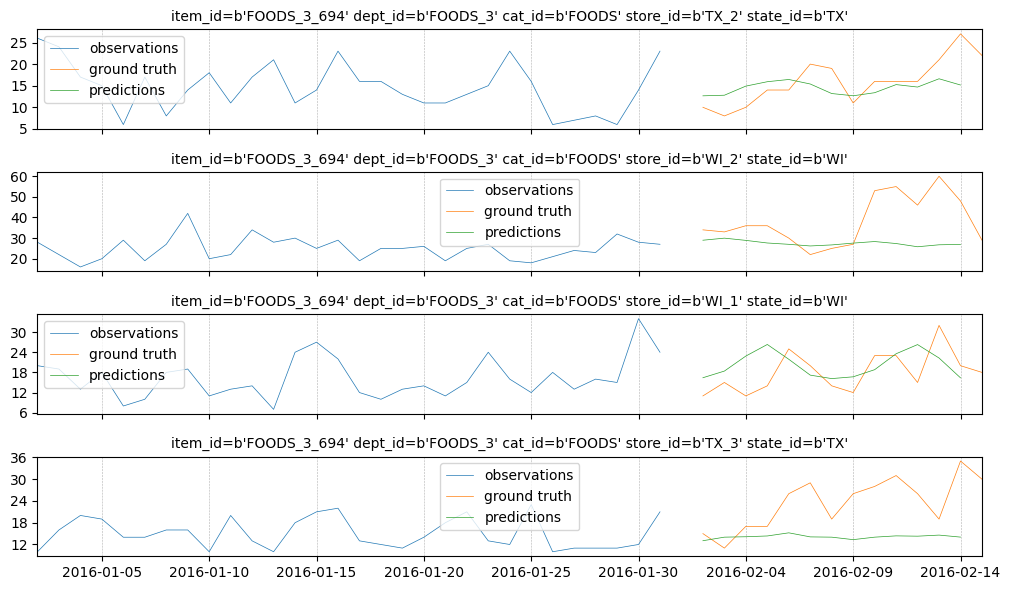

In [44]:
def compute_predictions_at_timepoint(predictions):
    index_names = test_examples.schema.index_names()
    rows = []
    for index_values, feature_values in predictions.data.items():

        # First prediction for each label
        values = [ feature[0] for feature in feature_values.features ]
        timestamps = map(datetime.utcfromtimestamp, feature_values.timestamps[:len(values)])
        # datetime.utcfromtimestamp(

        # TODO: Simplify code with Temporian's "from_struct" instead when available.
        # https://temporian.readthedocs.io/en/latest/reference/temporian/io/from_struct/
        index_map = { index_name:index_value for index_name, index_value in zip(index_names, index_values) }
        for value, timestamp in zip(values,timestamps):
            rows.append({"value": value, "timestamp": timestamp, **index_map})

    return tp.from_pandas(pd.DataFrame(rows), indexes = index_names)

predictions_at_point = compute_predictions_at_timepoint(predictions)

tp.plot([
    sales.before(end_train_cutoff).rename("observations"),
    sales.after(end_train_cutoff).rename("ground truth"),
    predictions_at_point.rename("predictions"),
],
        merge=True,
        max_num_plots=4,
        min_time= end_train_cutoff - timedelta(days=30),
        max_time= end_train_cutoff + timedelta(days=14),
       )

## More advanced features

In our first iteration, we only used lagged input features.
Now that we have our setup in place, we can experiment with more advances feature engineering to improve our model.
We will generate the following features:

- **Moving statistics**: Aggregation of past values over a moving window such as moving sum, moving average, moving standard deviation.
- **Calendar events**: Access to special calendar events e.g. father's day.
- **Calendar features**: Human activities are strongly related to the day of the week (people don't behave the same on mondays and sundays), day of the month and month of the day.
- **Hierarchical aggregations**: Aggregating values from related products e.g. products in the same departments or the same product in other stores.

### Moving statistics

Moving statistics are computed by appliying a statistical aggregation function (e.g. sum, mean, standard deviation, max, fft) over a window that "rolls" across the input time series.

The length of a window can be expressed in number of observations or in duration (those are different if the data is not sampled uniformly). The start of the window can also be important: A fixed length or variable length lag can be added. For instance, the time window can be lagged by 7 days or lagged to the end of the last full month.

Generally the optimal sizes and lags of the window are not known, so we can compute multiple windows with various values and let our model use the ones that provide the strongest signal.

#### Exercise

Fill the next cell to compute the moving mean and standard deviation with 4 window sizes without lags: 7, 14, 28 and 84 days.

The moving mean (also called moving average) and moving standard deviation, can be computed with Temporian's [simple_moving_average](https://temporian.readthedocs.io/en/latest/reference/temporian/operators/window/simple_moving_average/) and [moving_standard_deviation](https://temporian.readthedocs.io/en/latest/reference/temporian/operators/window/moving_standard_deviation/) respectively.

The number of plots (8) is larger than "options.max_num_plots=5". Only the first plots will be printed.


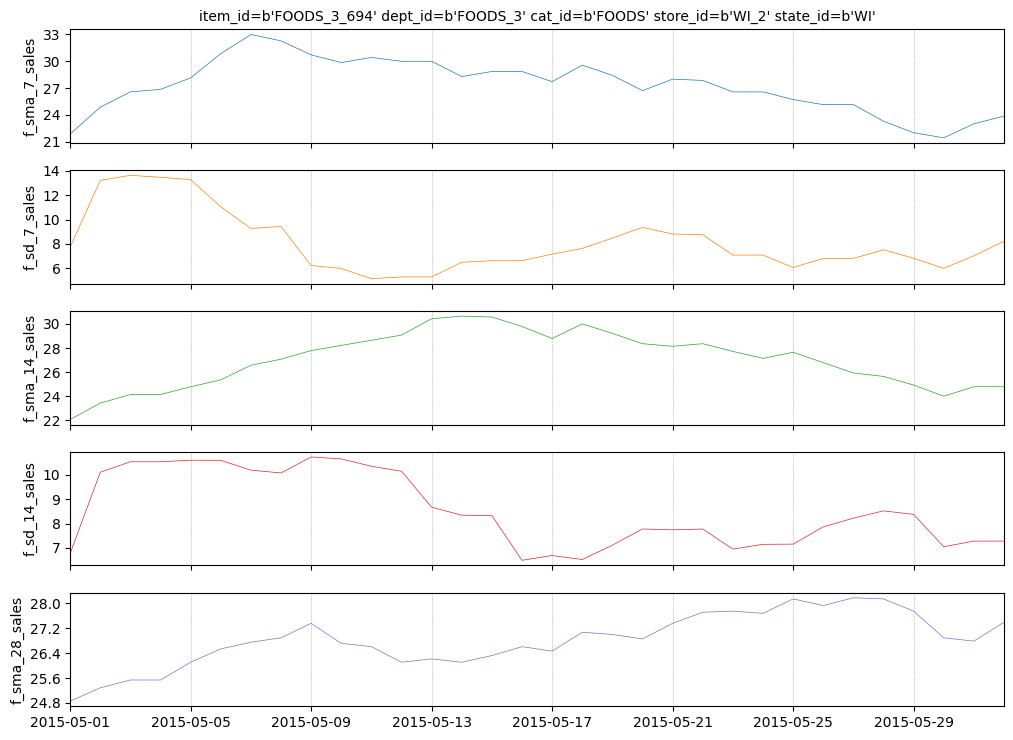

In [45]:
if SOLVING_EXERCISES:
  # Cast the sales to float32 (easier to handle).
  float_sales = sales["sales"].cast(tp.float32)

  features: list[tp.EventSet] = []
  for win_day in [7, 14, 28, 84]:
      win = tp.duration.days(win_day)

      # Compute the moving average
      # features.append(...)
      features.append(float_sales.simple_moving_average(win).prefix(f"f_sma_{win_day}_"))

      # Compute the moving standard deviation
      # features.append(...)
      features.append(float_sales.moving_standard_deviation(win).prefix(f"f_sd_{win_day}_"))

  feature_moving_stats = tp.glue(*features)

  # Plot the results.
  feature_moving_stats.plot(**plot_options, max_num_plots=5)

#### Solution

In [ ]:
float_sales = sales["sales"].cast(tp.float32)
features: list[tp.EventSet] = []
for win_day in [7, 14, 28, 84]:
    win = tp.duration.days(win_day)
    features.append(float_sales.simple_moving_average(win).prefix(f"f_sma_{win_day}_"))
    features.append(float_sales.moving_standard_deviation(win).prefix(f"f_sd_{win_day}_"))

feature_moving_stats = tp.glue(*features)
feature_moving_stats.plot(**plot_options, max_num_plots=5)

#### End of solution

#### Exercise and questions

Use code and markdown cells for the following:

1. Plot in the same plot the raw sales and the computed moving averages.
2. What can you tell about the **smoothing** and **apparent lag** of the moving averages compared to the raw sales?
3. Compute and plot the moving maximums.
4. Do you observe the same lag and smoothing?

#### Solution


1.

In [46]:
tp.plot([
    sales,
    feature_moving_stats[["f_sma_7_sales", "f_sma_14_sales", "f_sma_28_sales", "f_sma_84_sales"]],
],
        max_num_plots=1,
        merge=True,
        interactive=True,
        height_per_plot_px=300,
       )
# Note: Zoom on the data to see more details.


2.

Increasing the horizon makes the plot more shifted to the left and more smoothed.

3.

Add:

```python
features.append(float_sales.moving_max(win).prefix(f"f_max_{win_day}_"))
```

And plot with:

```python
feature_moving_stats[["f_max_7_sales", "f_max_14_sales", "f_max_28_sales", "f_max_84_sales"]]
```

4.

Increasing the window length decreases the number of "spikes" of the moving maximum, but they are still as sharp. The moving maximum operator is less stable/more noisy than the moving average operator.

#### End of solution

### Calendar features

A model such as a decision forest is not able to consume dates directly. Instead, we extract generalisable and possibly relevant features.

#### Question

1. Compute and plot the day of month, day of week, and month features. Check Temporian's [calendar_day_of_month](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/calendar/calendar_day_of_month/) and other calendar features.

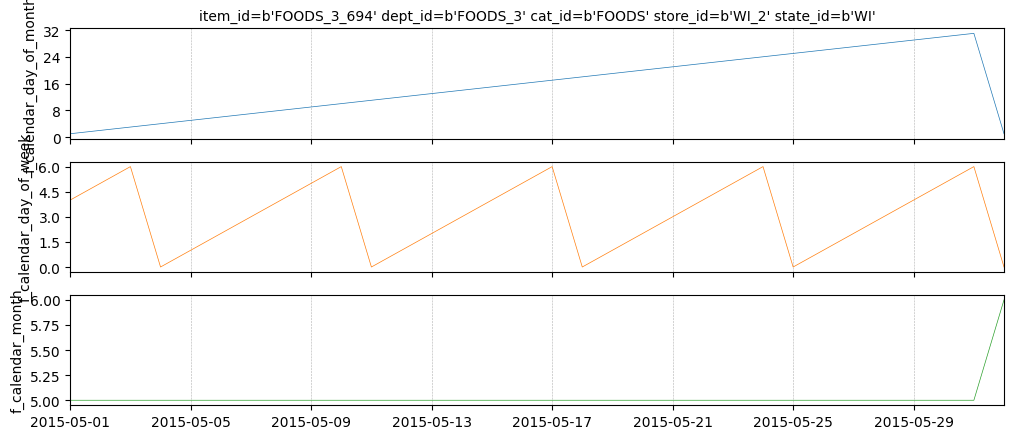

In [47]:
if SOLVING_EXERCISES:
  features: list[tp.EventSet] = []

  # Your code here.
  # features.append(...)
  features.append(sales.calendar_day_of_month())
  features.append(sales.calendar_day_of_week())
  features.append(sales.calendar_month())


  # Group the features together. Add "f_" for book keeping.
  feature_calendar = tp.glue(*features).prefix("f_")
  feature_calendar.plot(**plot_options, max_num_plots=5)

#### Solution

In [ ]:
features: list[tp.EventSet] = []
features.append(sales.calendar_day_of_month())
features.append(sales.calendar_day_of_week())
features.append(sales.calendar_month())
feature_calendar = tp.glue(*features).prefix("f_")

feature_calendar.plot(**plot_options, max_num_plots=5)

#### Question

1. On the plot of the day of the week, we can see slow up-slopes followed by sharp down-slopes. What do the down-slopes mean?

#### Solution



1. Down-slopes are artifacts created due to the linear interpolation between points, that happen when going from the last day of a week (6) to the first of the following (0). Adding the argument `style="marker"` to the plot, we can see the individual events without the slope.

### Calendar events

The dataset contains annotations of important events such as the NFL finals, father's day, or sales periods that can impact sales.

However, those events have an impact o sales before they happen (for example, the whole week before Christmas day has higher sales than most normal weeks), and since our model is only allowed to see anterior events, it won't be able to use it.

Instead, we can future-leak those events into the past, in the same way we computed the label. This is only possible because we know in advance when will be the next NFL final and father's day.

Most of those events are rare i.e. they happen once a year. Therefore, knowing how many events will happen in the next X days is not that informative. Instead, we can create a feature that expresses the number of days until the next event.

The list of all the available events is:

In [48]:
tp.to_pandas(calendar)["event_name_1"].unique()

array(['no_event', 'SuperBowl', 'ValentinesDay', 'PresidentsDay',
       'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End',
       'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day",
       'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

As an example, we'll (completely arbitrarily) pick the `SuperBowl`, `NBAFinalsEnd` and `Thanksgiving` events to create features for.

The number of plots (9) is larger than "options.max_num_plots=3". Only the first plots will be printed.


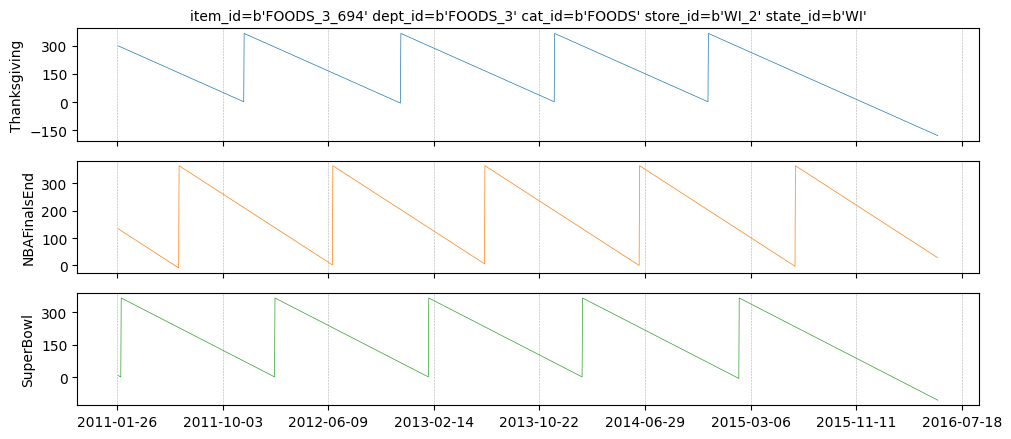

In [49]:
features = []

lag = tp.duration.days(365)
for event_name in ["Thanksgiving", "NBAFinalsEnd", "SuperBowl"]:

    # Select the events of interrest
    selected_events = calendar.filter(calendar["event_name_1"].equal(event_name))[[]]

    # Propagate (i.e., copy) the (global) special event to each product.
    selected_events_per_product = selected_events.propagate(sales)

    # Compute the time until the next events with a 365 days lag.
    feature_unique_next = ((lag - selected_events_per_product.leak(lag).since_last(sampling=sales)) / tp.duration.days(1)).rename(event_name)

    # Record the feature
    features.append(feature_unique_next)

feature_special_events = tp.glue(*features)
feature_special_events.plot(max_num_plots=3)

#### Question

1. Does the direction of the slopes make sense?
2. Why does the time to next event become negative at the end of the dataset? How would you solve it?

#### Solution



1. The feature expresses the time until the next event. The value falls as expected until it reaches the event.

2. `calendar` does not contain events for the period after our training data ends.

This could be solved by having calendar event records past the end of the dataset, or for fixed-date events, manually generating them with [tick_calendar](https://temporian.readthedocs.io/en/latest/reference/temporian/operators/tick_calendar/). For example, Thanksgiving is always on Nov 28.


### Hierarchical aggregations

We discussed above how sales are organized in two hierarchies: products/departments/category and store/state. So far, we have predicted sales of each product in each store in isolation. However, we can relax this constraint.

A straightforward solution to take hierarchy into account is through aggregations. In the next cell, we compute, for each product sale, the sum of all sales in the same department and store.

For example, the sales of bananas in store #1 will be combined with the sales of all fresh fruits in store #1. Similarly, the sales of nails will be combined with the sales of all hardware tools (assuming there are "fresh fruit" and "hardware tools" departments).

First, we merge together all the sales in the same department by removing `item_id` from the index. By removing the column from the index, we are telling Temporian that each independent time series is now only defined by the values in the remaining indexes (i.e. department/category and store/state).

In [50]:
sales_per_dept_and_store = sales.drop_index("item_id", keep=False)

print("Index of sales:", sales.schema.index_names())
print("Index of sales_per_dept:", sales_per_dept_and_store.schema.index_names())

Index of sales: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
Index of sales_per_dept: ['dept_id', 'cat_id', 'store_id', 'state_id']


We compute the 28 days moving sum of sales for this department.

In [51]:
# Create a daily sampling i.e. remove duplucate timestamps.
sampling_once_a_day = sales_per_dept_and_store.unique_timestamps()

# 28 days moving sum of sales per department and store.
sum_sales_per_dept_and_store = sales_per_dept_and_store.moving_sum(
        window_length=tp.duration.days(28),
        sampling=sampling_once_a_day
    )

# Give it a name for book-keeping.
sum_sales_per_dept_and_store = sum_sales_per_dept_and_store.prefix("f_sum28_per_dep-store_")

Finally, the aggregated sales per department and store is *propagated* back to each corresponding product - i.e., we are assigning to each item/store series the values that we computed for its corresponding department/store series.

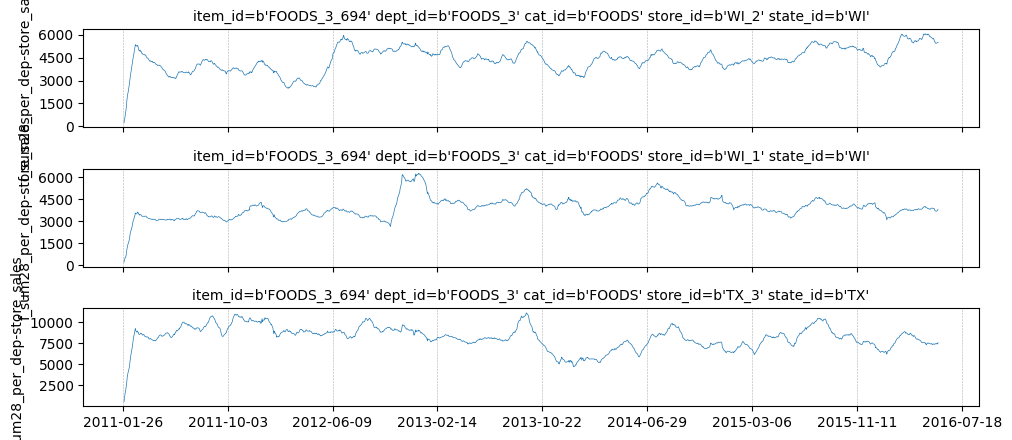

In [52]:
feature_hier_aggregation = sum_sales_per_dept_and_store.propagate(sales, resample=True)

feature_hier_aggregation.plot(max_num_plots=3)

## Re-training the model with all the available features

It is now time to retrain our model with all the features we computed.

In [53]:
# Aggregate all the features we computed.
features = tp.glue(
    feature_sales,
    feature_lagged_sales,
    feature_moving_stats,
    feature_calendar,
    feature_special_events,
    feature_hier_aggregation
)

feature_names = features.schema.feature_names()
print(f"There are {len(feature_names)} features: {feature_names}")

There are 21 features: ['sales', 'f_sales_lag1', 'f_sales_lag2', 'f_sales_lag3', 'f_sales_lag7', 'f_sales_lag14', 'f_sma_7_sales', 'f_sd_7_sales', 'f_sma_14_sales', 'f_sd_14_sales', 'f_sma_28_sales', 'f_sd_28_sales', 'f_sma_84_sales', 'f_sd_84_sales', 'f_calendar_day_of_month', 'f_calendar_day_of_week', 'f_calendar_month', 'Thanksgiving', 'NBAFinalsEnd', 'SuperBowl', 'f_sum28_per_dep-store_sales']


We split the dataset into a train and test split.

In [54]:
train_examples, test_examples = split_train_test(tp.glue(features, labels))

We train the models:

In [55]:
models = train_models(train_examples)

Train model for label 'label_h1'
Train model on 144880 examples
Model trained in 0:00:27.750763
Train model for label 'label_h2'
Train model on 144880 examples
Model trained in 0:00:27.352986
Train model for label 'label_h3'
Train model on 144880 examples
Model trained in 0:00:26.944473
Train model for label 'label_h4'
Train model on 144880 examples
Model trained in 0:00:27.047298
Train model for label 'label_h5'
Train model on 144880 examples
Model trained in 0:00:27.463370
Train model for label 'label_h6'
Train model on 144880 examples
Model trained in 0:00:27.064565
Train model for label 'label_h7'
Train model on 144880 examples
Model trained in 0:00:27.071841
Train model for label 'label_h8'
Train model on 144880 examples
Model trained in 0:00:27.044285
Train model for label 'label_h9'
Train model on 144880 examples
Model trained in 0:00:26.881680
Train model for label 'label_h10'
Train model on 144880 examples
Model trained in 0:00:26.797782
Train model for label 'label_h11'
Train

Once again, we take a look at the model.

In [56]:
models[-1].describe()

#### Question

1. Are the new features used by the model? Which feature seems to matter the most to the model?

#### Solution


1. The moving sum of sales are now the most important features to the model. The aggregated sales per department and store seem to have little importance.

#### End of solution

We evaluate the model.

RMSE for label 'label_h1': 10.1121
RMSE for label 'label_h2': 10.9006
RMSE for label 'label_h3': 10.8263
RMSE for label 'label_h4': 10.8727
RMSE for label 'label_h5': 11.0070
RMSE for label 'label_h6': 10.9104
RMSE for label 'label_h7': 11.0216
RMSE for label 'label_h8': 12.3947
RMSE for label 'label_h9': 12.2656
RMSE for label 'label_h10': 11.9968
RMSE for label 'label_h11': 11.9500
RMSE for label 'label_h12': 11.8402
RMSE for label 'label_h13': 13.1297


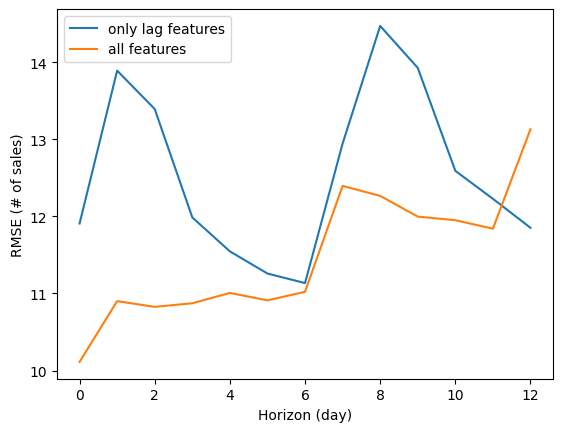

In [57]:
rmses_per_horizon_all_features = evaluate_models(models, test_examples)

plt.plot(rmses_per_horizon_lag_features, label="only lag features")
plt.plot(rmses_per_horizon_all_features, label="all features")
plt.xlabel("Horizon (day)")
plt.ylabel("RMSE (# of sales)")
plt.legend()

We can see that the prediction RMSE has slightly improved compared to the model with only the lag features.

#### Question

1. Why is there an overall positive slope? Is this expected?

#### Solution


1. The curves shows that predicting next day's sales is easier that predicting sales further away in the future (e.g. in two weeks). This make sense as predicting further in the future is generally more complex, as we have less data available for it: predicting tomorrow's weather is easier than predicting next week's.

#### End of solution